# eCommerce Product Recommendation - Part 1
某外卖电商平台的[匿名数据](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)进行复购商品推荐. 



不要一上来讲model（part 3）更多的70%重点在（part1&2）EDA，business sense，background info，等等，一定是business导向，如果research组更多看model.第一轮recruiter（猎头）的时候可以问，这个工作的性质，是偏research还是business。下面code引用的时候一定记得改变量名！！！！！！！

# 1. Load Raw Data to Colab

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Laioffer/csv_files/RecSys_eComm/

/content/drive/MyDrive/Laioffer/csv_files/RecSys_eComm


In [ ]:
ls

 aisles.csv                model_all_data.csv         order_products_train.csv
 departments.csv           model.png                  orders.csv
'model_all_data (1).csv'   order_products_prior.csv   products.csv


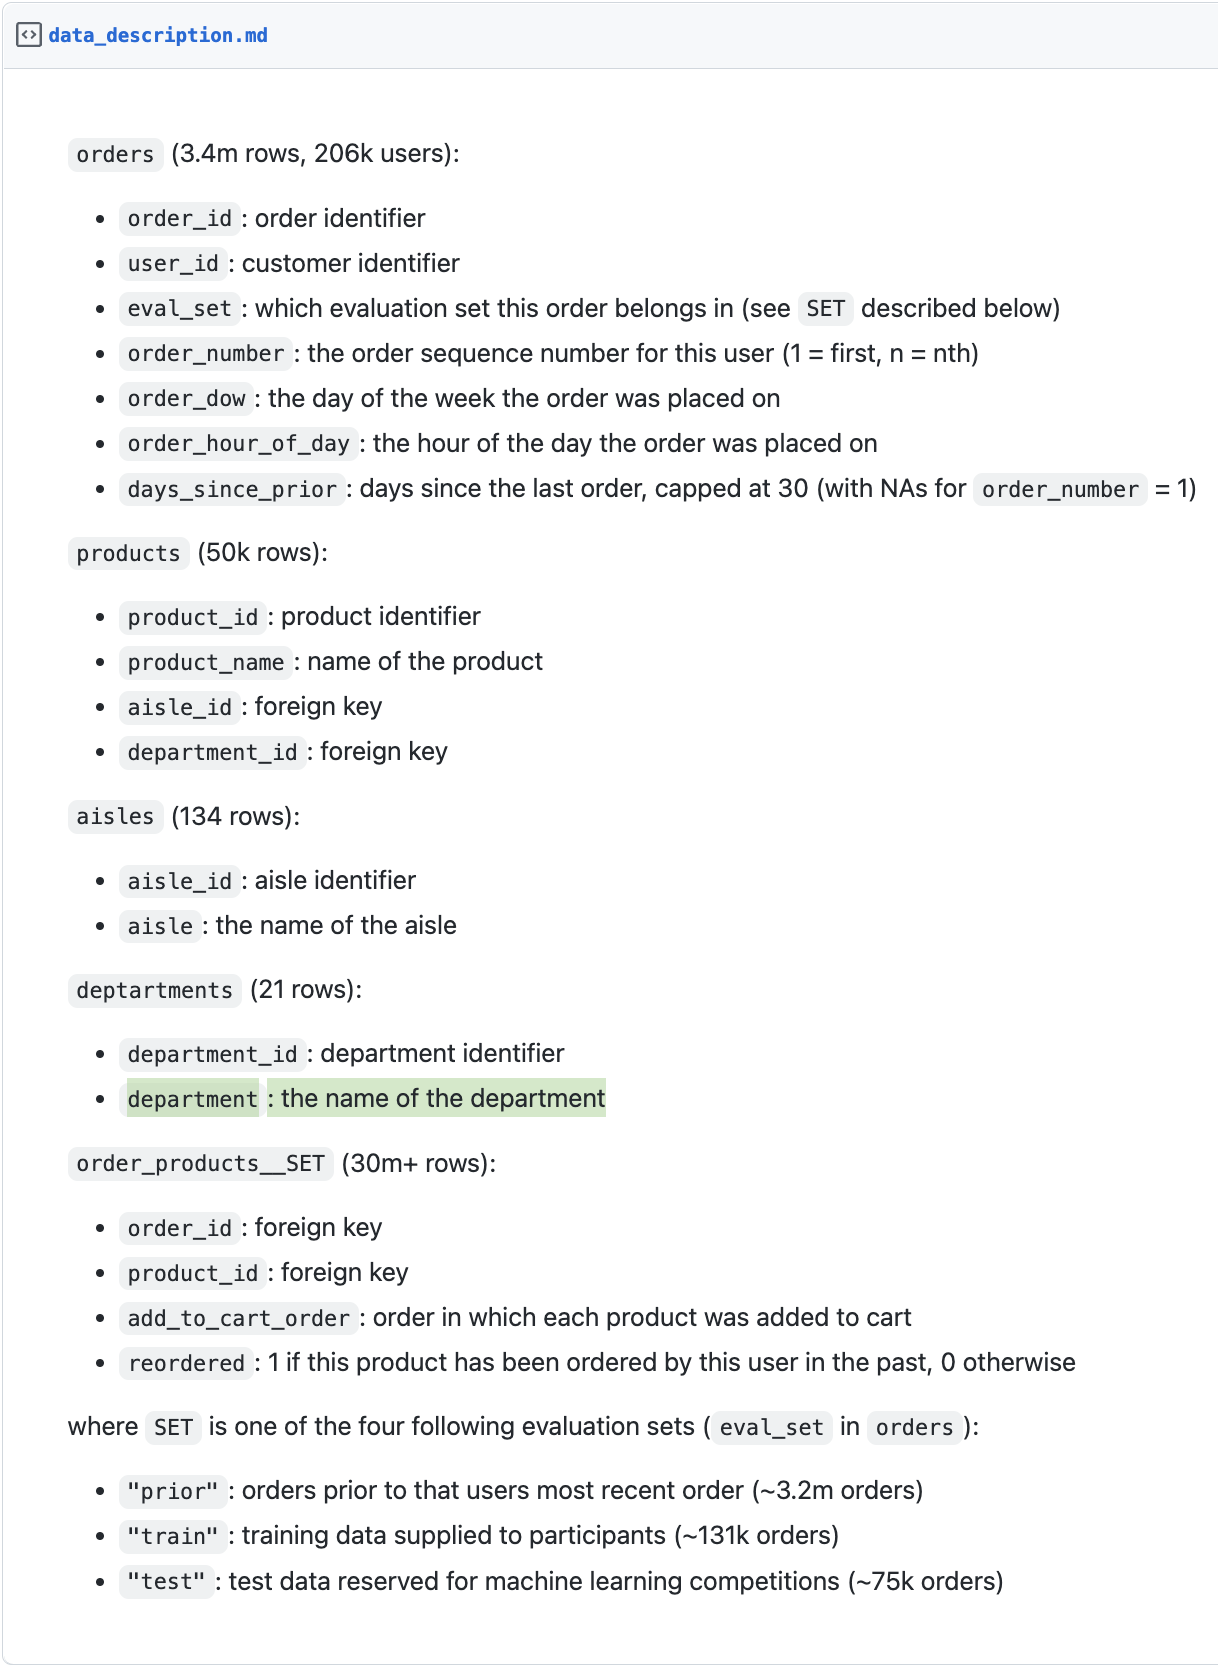

In [ ]:
aisles = pd.read_csv('aisles.csv') 
departments = pd.read_csv('departments.csv') 
order_products_prior = pd.read_csv('order_products_prior.csv') # ?
order_products_train = pd.read_csv('order_products_train.csv') # ?
orders = pd.read_csv('orders.csv') 
products = pd.read_csv('products.csv') 

In [ ]:
print(aisles.shape)
print(departments.shape)
print(order_products_prior.shape)
print(order_products_train.shape)
print(orders.shape)
print(products.shape)

(134, 2)
(21, 2)
(793924, 4)
(53704, 4)
(82683, 7)
(49688, 4)


In [ ]:
aisles.head() # 不重要
# aisle_id: aisle identifier
# aisle: the name of the aisle

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
departments.head() # 不重要
# department_id: department identifier
# department: the name of the department

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
orders.head() # Dimensional Table 描述关系信息
# order_id: order identifier
# user_id: customer identifier
# eval_set: which evaluation set this order belongs in (see SET described below)
# order_number: the order sequence number for this user (1 = first, n = nth)
# order_dow: the day of the week the order was placed on
# order_hour_of_day: the hour of the day the order was placed on
# days_since_prior: days since the last order, capped at 30 (with NANs for order_number = 1) ##面试时要挖掘出来的信息

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [ ]:
products.head() # Dimensional Table 描述关系信息
# product_id: product identifier
# product_name: name of the product
# aisle_id: foreign key
# department_id: foreign key

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
order_products_prior.head()  # Factor Table
# reordered ?????? -> 要我何用？？？ #这里的reorder不是我们要predict的那个value，是指以后我们又买过相同的产品
#有这种机会，一定抓住，冷静，慢慢问，calm and friendly，展现出自己的性格，让interviewer觉得自己是个好相处的人，性格好，因为面试官里面会有以后的同事
# relationship of order and product
# "prior": orders prior to that users most recent order (~3.2m orders)

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [ ]:
order_products_train.head() # Factor Table
# "train": training data supplied to participants (~131k orders)

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


# 2. Data Exploration

2.1 Build order history table `prior_order_details`

In [ ]:
# Build prior order details table for data exploration
prior_order_details = order_products_prior.merge(orders, on="order_id")
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [ ]:
# Covert dow to string for better visualization
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Sunday" if x==0 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Monday" if x==1 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Tuesday" if x==2 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Wednesday" if x==3 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Thursday" if x==4 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Friday" if x==5 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Saturday" if x==6 else x)
#因为之后要画图，所以把星期decode之后方便后面visualize

In [ ]:
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0
1,12,15221,2,1,152610,prior,22,Saturday,8,10.0
2,12,43772,3,1,152610,prior,22,Saturday,8,10.0
3,12,37886,4,1,152610,prior,22,Saturday,8,10.0
4,12,37215,5,0,152610,prior,22,Saturday,8,10.0


2.2 Visualize order frequency on DoW

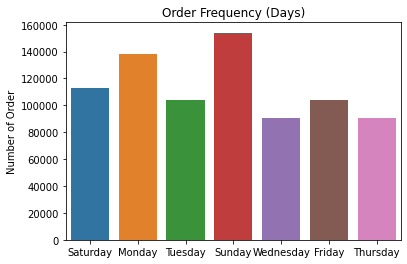

In [ ]:
#Frequency of Order Based on Days
ax = sns.countplot(x="order_dow",data=prior_order_details)
plt.title("Order Frequency (Days)")
plt.xlabel("")
plt.ylabel("Number of Order")
plt.show()
#问题：MOn之后顺序不对，显现出自己不是detail- oriented

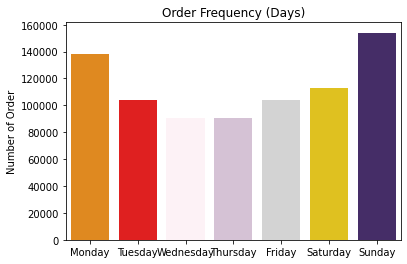

In [ ]:
#Frequency of Order Based on Days
ax = sns.countplot(x="order_dow",data=prior_order_details,
                   order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Order Frequency (Days)")
plt.xlabel("")
plt.ylabel("Number of Order")
plt.show()

1.3 Visualize order frequency on HoD

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


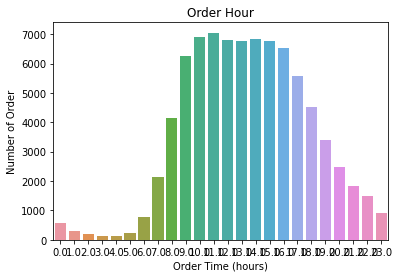

In [ ]:
order_hours_counts = orders.groupby("order_id")["order_hour_of_day"].mean().reset_index()
order_hod_stats = order_hours_counts.order_hour_of_day.value_counts()
sns.barplot(order_hod_stats.index, order_hod_stats.values)
plt.title("Order Hour")
plt.ylabel("Number of Order")
plt.xlabel('Order Time (hours)')
plt.show()

1.4 Reorder Pattern Analysis

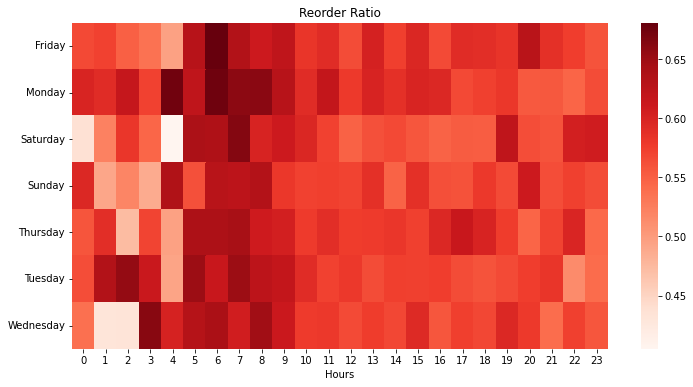

In [ ]:
reorder_heatmap = prior_order_details.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
reorder_heatmap = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')
plt.figure(figsize=(12,6))
sns.heatmap(reorder_heatmap,cmap="Reds")
plt.title("Reorder Ratio")
plt.ylabel("")
plt.xlabel("Hours")
plt.show()
#发现什么时间买的最多---》很多insight

Homework 1: Find the top3 popular product/Aisle/Department

# 2. Data Quality Check

2.1. Validate the `days_since_prior_order` column in orders table

In [ ]:
orders.head() # days since the last order (with NAs for order_number = 1)
# 模型不支持Nan数据，需要补齐。
# 消除NaN时，要看与前面数据的关系！！！

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [ ]:
print("Value size of the order dataset: ", orders.shape[0])
print("NaN count in days_since_prior_order column: ", orders[orders.days_since_prior_order.isnull()].shape[0])
print("order_number 1 count in orders table: ", orders[orders.order_number == 1].drop_duplicates().shape[0])
print("user_id count in orders table: ", orders.user_id.drop_duplicates().shape[0])

Value size of the order dataset:  82683
NaN count in days_since_prior_order column:  5000
order_number 1 count in orders table:  5000
user_id count in orders table:  5000


由此可见, 在orders.csv里，缺失days_since_prior_order的行数，等同于order_number == 1的行数，也对应user的个数。

2.2.Validate Valid orders matching in the prior table

In [ ]:
# orders.csv里面，不同eval_set的orders个数：
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('order_id','nunique')]))

,eval_set,order_id
0,prior,77683
1,train,5000


In [ ]:
# 验证：order_products_prior.csv 里面的 order_id 都在 orders.csv 里 (确保所有prior orders仍然真实存在)
print("order_id count in prior: ", order_products_prior['order_id'].nunique())
print("order_id from prior found in orders: ", order_products_prior[order_products_prior.order_id.isin(orders.order_id)].order_id.nunique()) #即使nunique（）一样，但也可能是巧合，还是需要精确check

order_id count in prior:  77683
order_id from prior found in orders:  77683


2.3. Validate orders matching in the train table

In [ ]:
# 验证: order_products_train.csv 里面的 order_id 都在 orders.csv 里 (确保所有train orders仍然真实存在)
print("orders count in train: ", order_products_train['order_id'].nunique())
print("order_id from train found in orders: ", order_products_train[order_products_train.order_id.isin(orders.order_id)].order_id.nunique())

orders count in train:  5000
order_id from train found in orders:  5000


2.4. Validate the intersection between prior and train table

In [ ]:
# 验证：order_products_prior.csv 和 order_products_train.csv 里面的order_id没有交集
print("order_id intersection between prior and train: ", pd.merge(order_products_prior, order_products_train, on = ['order_id']).shape[0])

order_id intersection between prior and train:  0


2.5. Validate the user_id matching in prior and train set

In [ ]:
# orders.csv里面，不同eval_set中user个数：
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('user_id','nunique')]))

,eval_set,user_id
0,prior,5000
1,train,5000


In [ ]:
prior_user_ids = set(orders[orders['eval_set'] == 'prior']['user_id'])
train_user_ids = set(orders[orders['eval_set'] == 'train']['user_id'])
print("user_ids in prior: ", len(prior_user_ids))
print("user_ids in train: ", len(train_user_ids))
print("intersection of prior and train: ", len(prior_user_ids.intersection(train_user_ids)))

user_ids in prior:  5000
user_ids in train:  5000
intersection of prior and train:  5000
